In [1]:
import osmnx as ox
import osmnx.graph
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkb
from pathlib import Path
import matplotlib.pyplot as plt
import sys

sys.path.append("../")
from data_pipeline.dp03_road_graph import gkey_hash


data_folder = Path("/Users/aaaje/Documents/ETH_WORK/thesis/data/t4f2022")

city = "melbourne"

city_road_graph_folder = data_folder / "road_graph" / city


graph_file = city_road_graph_folder / "road_graph.gpkg"


road_filtered_file = data_folder / "adj" / city / "road_filtered_with_id.parquet"

adj_file = data_folder / "adj" / city / "adjacency_mat_filtered.csv"

In [3]:
g = gpd.read_file(graph_file, layer="edges")
# gkey generation
# As there are some rare notorious situations, where there are two different ways between the same two nodes
# (u,v,osmid) is not unique, so let's generate hash based on geometry to differentiate.
g["gkey"] = [gkey_hash(wkb.dumps(geo)) for geo in g["geometry"]]
# Fiona has problems with uint64: https://github.com/Toblerity/Fiona/issues/365
g["gkey"] = g["gkey"].astype("int64")

In [4]:
g[g["highway"].isin(["motorway"])].groupby("name").agg({"gkey":"count"}).sum()

gkey    350
dtype: int64

In [11]:
road = pd.read_parquet(road_filtered_file)
road = gpd.GeoDataFrame(road, geometry=wkb.loads(road["geometry_x"]), crs=g.crs)

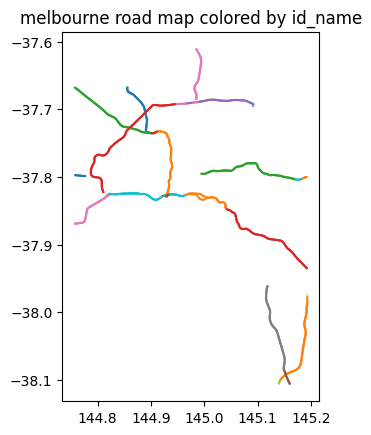

In [12]:
c = "id_name"
road.plot(column=c, legend=False, categorical=True)
plt.title(f"{city} road map colored by {c}")
plt.savefig(f"./fig/{city}-{c}-map.png", bbox_inches="tight")
plt.show()

<Axes: >

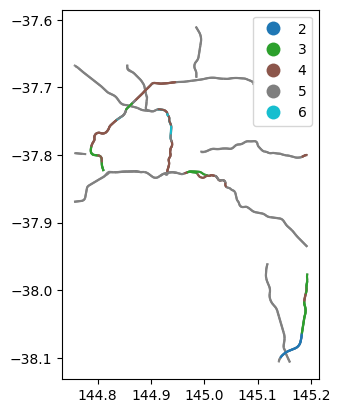

In [53]:
fig, ax = plt.subplots()
road.plot(ax=ax, color="grey")
road[road["id_name"].isin([-1031548208597292382,-5984391051177317169,-7043009845107998839])].plot(column="id_lanes", ax=ax, legend=True, categorical=True)


In [7]:
road.groupby("id_name").agg({"gkey":"count"})

,gkey
id_name,
-8041324114396079828,22
-7394525319820086292,4
-7095154088863854312,1
-7043009845107998839,22
-6784025066360910388,2
-5984391051177317169,32
-3976661809117977864,2
-2250391345121474174,35
-1750612930673714027,27


In [60]:
# Adjacency matrix
adj = pd.read_csv(adj_file, header=None, index_col=None).values
adj.shape

(350, 350)

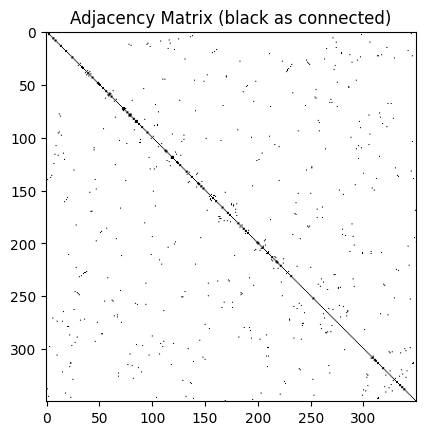

In [91]:
# plot orginal adj
plt.imshow(adj, cmap="binary")
plt.title("Adjacency Matrix (black as connected)")
plt.show()

In [106]:
def permutate_adj(adj, p, CONNECTED):
    locs = np.argwhere(adj!=CONNECTED)
    print(locs.shape)
    max_size = int(locs.shape[0]*p)
    # select some pixels to turn on randomly
    idx = np.random.choice(np.arange(locs.shape[0]), size=max_size, replace=False)
    # get pixels
    locs_ = locs[idx]
    # turn on selected pixels
    adj_r = adj.copy()
    i, j = locs_[:,0], locs_[:,1]
    adj_r[i,j] = 1 - (not CONNECTED)

    print(f"Connected edges: before={adj.sum()}, after={adj_r.sum()}, expected changed={max_size}")
    return adj_r

In [107]:
# randomly add connections
p = 0.2

CONNECTED = 1. #1: add more; 0: reduce num_edges
adj_r = permutate_adj(adj, p, CONNECTED)
np.savetxt(data_folder / "adj" / city / f"adj_syn_p{p}_{'add' if CONNECTED else 'reduce'}.csv", adj_r, delimiter=",")

(121456, 2)
Connected edges: before=1044.0, after=25335.0, expected changed=24291


In [108]:
350*350-1044

121456

Text(0.5, 1.0, 'Adjacency Matrix (black as connected)')

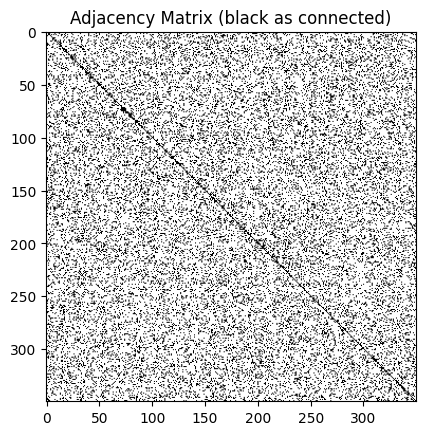

In [105]:
plt.imshow(adj_r, cmap="binary")
plt.title("Adjacency Matrix (black as connected)")